In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score
from tensorflow.keras.datasets import mnist
from sklearn import datasets

In [2]:
class Adaact(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
    
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.k0 = self.add_weight(
            name="k0", shape=[1], initializer="glorot_normal")
        self.k1 = self.add_weight(
            name="k1", shape=[1], initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) 
            
    def call(self, X):
        z = X @ self.kernel + self.bias
        return self.k0 + self.k1*z
            
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
            
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "k0": self.k0, "k1": self.k1}


In [48]:
import pandas as pd
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/banknote_authentication.csv'
df = pd.read_csv(url, header=None)
print(df.shape)

(1372, 5)


In [49]:
df.describe()

,0,1,2,3,4
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


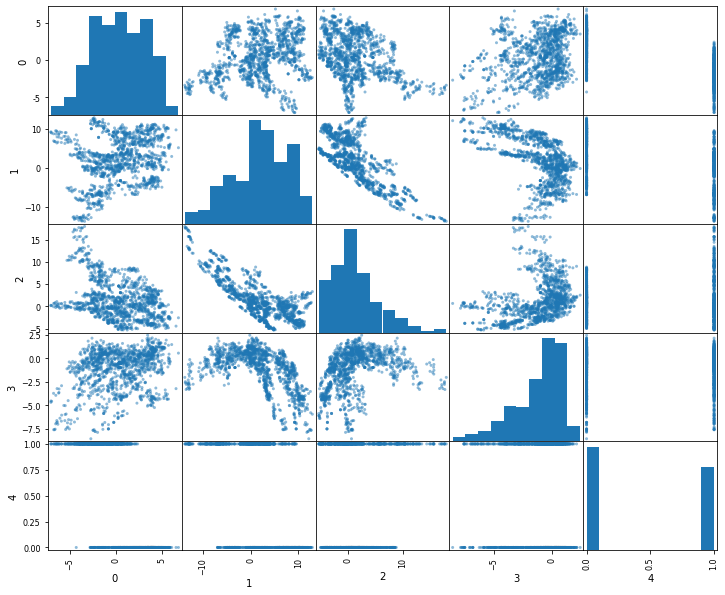

In [50]:
plt.rcParams["figure.figsize"] = (12,10)
pd.plotting.scatter_matrix(df)
plt.show()


In [51]:
X, y = df.values[:, :-1], df.values[:, -1]
X = X.astype('float32')
input_shape = X[0].shape
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=42)

In [52]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [53]:
model1= keras.Sequential([
    Adaact(10,input_shape=input_shape),
    keras.layers.Dense(1,activation='sigmoid')
])

weights_dict = {}
weight_cb = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: weights_dict.update({epoch:model1.get_weights()}))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

model1.compile(optimizer='nadam', loss='binary_crossentropy',metrics=['accuracy'])


In [54]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
adaact (Adaact)              (None, 10)                52        
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test,y_test),
                       callbacks=[early_stopping_cb,weight_cb])

Epoch 1/50
33/33 [==============================] - 1s 10ms/step - loss: 0.5789 - accuracy: 0.7021 - val_loss: 0.5325 - val_accuracy: 0.7114
Epoch 2/50
33/33 [==============================] - 0s 3ms/step - loss: 0.4802 - accuracy: 0.7576 - val_loss: 0.4519 - val_accuracy: 0.7464
Epoch 3/50
33/33 [==============================] - 0s 4ms/step - loss: 0.4275 - accuracy: 0.7798 - val_loss: 0.3977 - val_accuracy: 0.7872
Epoch 4/50
33/33 [==============================] - 0s 3ms/step - loss: 0.3557 - accuracy: 0.8361 - val_loss: 0.3542 - val_accuracy: 0.8280
Epoch 5/50
33/33 [==============================] - 0s 3ms/step - loss: 0.3530 - accuracy: 0.8327 - val_loss: 0.3165 - val_accuracy: 0.8571
Epoch 6/50
33/33 [==============================] - 0s 3ms/step - loss: 0.2898 - accuracy: 0.8883 - val_loss: 0.2826 - val_accuracy: 0.8746
Epoch 7/50
33/33 [==============================] - 0s 4ms/step - loss: 0.2439 - accuracy: 0.9068 - val_loss: 0.2522 - val_accuracy: 0.8834
Epoch 8/50
33/33 [=

In [90]:
for epoch,weights in weights_dict.items():
    print("Value of k0 in epoch #",epoch+1)
    print(weights[1])
    print("Value of k1 in epoch #",epoch+1)
    print(weights[2])
    print("Value of kernel in epoch #",epoch+1)
    print(weights[0])
    print("Value of Bias in epoch #",epoch+1)
    print(weights[3])

Value of k0 in epoch # 1
[0.0730893]
Value of k1 in epoch # 1
[-0.6123622]
Value of kernel in epoch # 1
[[ 0.16547616 -0.38657567  0.16334058 -0.62813556 -0.2686788   0.00209985
   0.4010819   0.5170931   0.12381834  0.3340048 ]
 [ 0.37816483  0.07823794  0.7636261   0.41636562  0.5292904  -0.55888367
  -0.4239205  -0.41983947  0.26059705  0.5187626 ]
 [-0.59312254  0.22694173  0.39802632  0.4995043   0.05566921  0.40805307
  -0.19289756 -0.44976866  0.23336677  0.14933383]
 [ 0.20755047 -0.32111105  0.17588486  0.17483708 -0.11907467  0.40892434
   0.20538732 -0.05640145  0.39718917  0.7043046 ]]
Value of Bias in epoch # 1
[ 0.02165566 -0.02139329  0.0229003  -0.02028123 -0.02159006 -0.02212992
  0.02133877  0.02145916 -0.02143746  0.02204943]
Value of k0 in epoch # 2
[0.05246528]
Value of k1 in epoch # 2
[-0.604885]
Value of kernel in epoch # 2
[[ 0.19130862 -0.41152856  0.19439162 -0.6468296  -0.29464155 -0.02494083
   0.4258782   0.54224133  0.09884643  0.36178237]
 [ 0.39250785  0

In [91]:
print("Final Parameters")
model1.layers[0].get_weights()

Final Parameters


[array([[ 0.4331637 , -0.7604027 ,  0.7258798 , -0.11757491, -0.6511549 ,
         -0.30867222,  0.78867275,  0.81898874, -0.14510328,  0.7563108 ],
        [ 0.46268493, -0.03624178,  0.9282553 ,  0.52968824,  0.41125986,
         -0.65682083, -0.30554324, -0.3240538 ,  0.17403491,  0.6480678 ],
        [-0.3338436 , -0.11804388,  0.90175015,  0.90858126, -0.30067798,
          0.1167918 ,  0.16022417, -0.16469783, -0.02215635,  0.54023635],
        [ 0.02702122, -0.07357608, -0.16158204, -0.13676324,  0.13397476,
          0.6182691 , -0.05115252, -0.2613992 ,  0.5810563 ,  0.4315213 ]],
       dtype=float32),
 array([0.4707626], dtype=float32),
 array([-1.2746757], dtype=float32),
 array([-0.23778619,  0.38039356, -0.51358956, -0.7088596 ,  0.37959912,
         0.30391404, -0.40039393, -0.29533747,  0.25704655, -0.40772584],
       dtype=float32)]

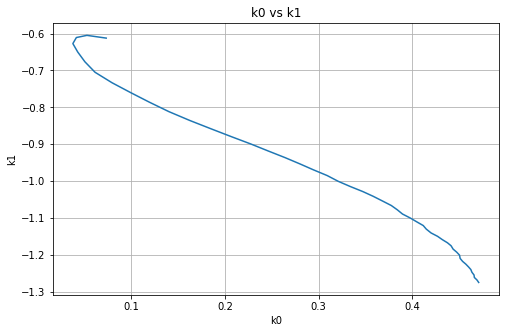

In [101]:
k0_1 = []
k1_1 = []
for idx in weights_dict.keys():
    k0_1.append((weights_dict[idx][1]))
    k1_1.append((weights_dict[idx][2]))

plt.rcParams["figure.figsize"] = (8,5)
plt.plot(k0_1,k1_1)
plt.grid(True)
plt.title("k0 vs k1")
plt.xlabel("k0")
plt.ylabel("k1")
plt.show()

In [58]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 33}

In [59]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

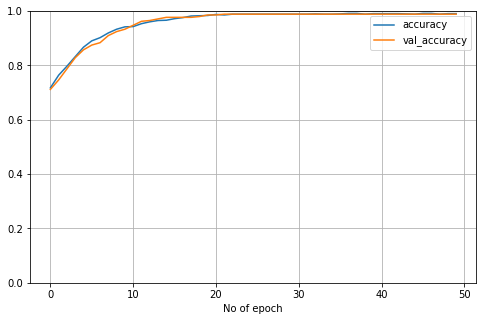

In [60]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(history.epoch,pd.DataFrame(history.history)[['accuracy','val_accuracy']])
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.legend(["accuracy","val_accuracy"])
plt.xlabel("No of epoch")
plt.show()

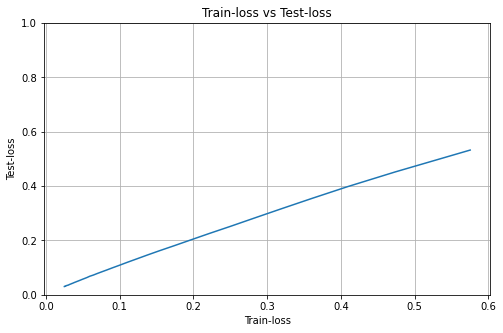

In [61]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(pd.DataFrame(history.history)['loss'],pd.DataFrame(history.history)['val_loss'])
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Train-loss vs Test-loss")
plt.xlabel("Train-loss")
plt.ylabel("Test-loss")
plt.show()

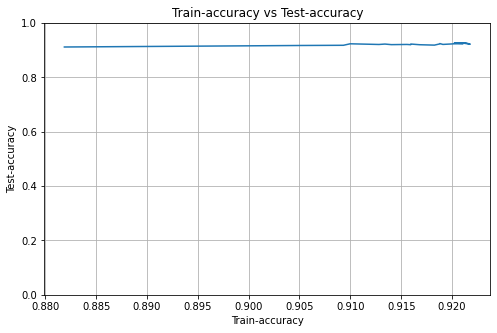

In [62]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(pd.DataFrame(history2.history)['accuracy'],pd.DataFrame(history2.history)['val_accuracy'])
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Train-accuracy vs Test-accuracy")
plt.xlabel("Train-accuracy")
plt.ylabel("Test-accuracy")
plt.show()

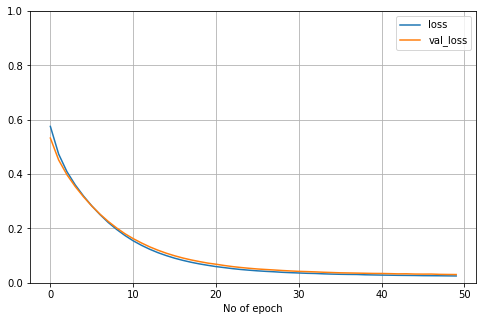

In [63]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(history.epoch,pd.DataFrame(history.history)[['loss','val_loss']])
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.legend(["loss","val_loss"])
plt.xlabel("No of epoch")
plt.show()

In [64]:
model1.evaluate(X_train,y_train)

33/33 [==============================] - 0s 1ms/step - loss: 0.0246 - accuracy: 0.9913


[0.024637239053845406, 0.991253674030304]

In [65]:
model1.evaluate(X_test,y_test)

11/11 [==============================] - 0s 1ms/step - loss: 0.0304 - accuracy: 0.9883


[0.03042447380721569, 0.9883381724357605]

In [66]:
y_pred = model1.predict_classes(X_test)
f1_score(y_test,y_pred)

c:\users\deepd\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.9868421052631579

In [9]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [10]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

In [11]:
input_shape2= train_images[0].shape

In [12]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
model2 = keras.Sequential([
    Adaact(64,input_shape=input_shape2),
    keras.layers.BatchNormalization(),
    Adaact(32),
    keras.layers.Dense(10,activation='softmax')
])

weights_dict2 = {}
weight_cb2 = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: weights_dict2.update({epoch:model2.get_weights()}))

early_stopping_cb2 = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [86]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
adaact (Adaact)              (None, 64)                50242     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
adaact_1 (Adaact)            (None, 32)                2082      
_________________________________________________________________
dense (Dense)                (None, 10)                330       
Total params: 52,910
Trainable params: 52,782
Non-trainable params: 128
_________________________________________________________________


In [14]:
history2 = model2.fit(train_images, train_labels, epochs=50, batch_size=32, validation_data=(test_images,test_labels),
                       callbacks=[early_stopping_cb2,weight_cb2])

Epoch 1/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6324 - accuracy: 0.8446 - val_loss: 0.3045 - val_accuracy: 0.9117
Epoch 2/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3270 - accuracy: 0.9051 - val_loss: 0.2900 - val_accuracy: 0.9173
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3211 - accuracy: 0.9091 - val_loss: 0.2834 - val_accuracy: 0.9180
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3149 - accuracy: 0.9082 - val_loss: 0.2799 - val_accuracy: 0.9235
Epoch 5/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3127 - accuracy: 0.9101 - val_loss: 0.2737 - val_accuracy: 0.9210
Epoch 6/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3060 - accuracy: 0.9128 - val_loss: 0.2753 - val_accuracy: 0.9225
Epoch 7/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2945 - accuracy: 0.9145 - val_loss: 0.2779 - val_accuracy:

In [102]:
for epoch,weights in weights_dict2.items():
    print("Value of k0 in epoch #",epoch+1)
    print(weights[1])
    print("Value of k1 in epoch #",epoch+1)
    print(weights[2])
    print("Value of kernel in epoch #",epoch+1)
    print(weights[0])
    print("Value of Bias in epoch #",epoch+1)
    print(weights[3])

Value of k0 in epoch # 1
[0.0949788]
Value of k1 in epoch # 1
[-0.73156697]
Value of kernel in epoch # 1
[[ 0.0180796  -0.04652152  0.01763599 ... -0.0654212   0.09099182
  -0.05437881]
 [-0.08810689 -0.06793077 -0.02375035 ... -0.08400621 -0.04089812
  -0.01803301]
 [-0.0619554  -0.00524685  0.01873137 ... -0.03946084 -0.04514297
   0.09283177]
 ...
 [-0.02824675  0.00569637 -0.00764325 ...  0.04950488 -0.01602927
  -0.06306607]
 [-0.03085351  0.00352899  0.01372383 ... -0.09228438  0.07128725
   0.03699109]
 [-0.06406836  0.01195095  0.0090136  ... -0.05536285 -0.02727608
   0.05153397]]
Value of Bias in epoch # 1
[-7.84611038e-04  6.58595702e-04 -1.86630362e-03 -9.52035014e-04
  5.00383263e-04 -9.44130938e-04 -3.81126796e-04 -2.48852914e-04
 -1.82403382e-04 -1.26967055e-03  4.03137587e-04 -8.63434980e-04
  3.47609021e-04  3.68039211e-04 -3.06969378e-06  6.85625360e-04
  5.04421594e-04  1.44221471e-03  8.53159581e-04  1.40567237e-04
 -7.15723960e-04 -6.34718454e-04 -4.41385491e-04 -1

In [105]:
model2.layers[0].get_weights()

[array([[ 0.0180796 , -0.04652152,  0.01763599, ..., -0.0654212 ,
          0.09099182, -0.05437881],
        [-0.08810689, -0.06793077, -0.02375035, ..., -0.08400621,
         -0.04089812, -0.01803301],
        [-0.0619554 , -0.00524685,  0.01873137, ..., -0.03946084,
         -0.04514297,  0.09283177],
        ...,
        [-0.02824675,  0.00569637, -0.00764325, ...,  0.04950488,
         -0.01602927, -0.06306607],
        [-0.03085351,  0.00352899,  0.01372383, ..., -0.09228438,
          0.07128725,  0.03699109],
        [-0.06406836,  0.01195095,  0.0090136 , ..., -0.05536285,
         -0.02727608,  0.05153397]], dtype=float32),
 array([0.13041113], dtype=float32),
 array([-1.0896251], dtype=float32),
 array([-1.1673496e-03,  1.3339492e-03, -2.9446408e-03, -2.8652232e-03,
         7.4194674e-04, -1.9852694e-03, -1.7574726e-03, -4.4922839e-05,
        -2.8589135e-03,  2.5891203e-03,  2.2133379e-03, -4.9366010e-03,
         5.7422515e-04, -8.6590066e-05, -1.1198259e-03, -3.8489208e-

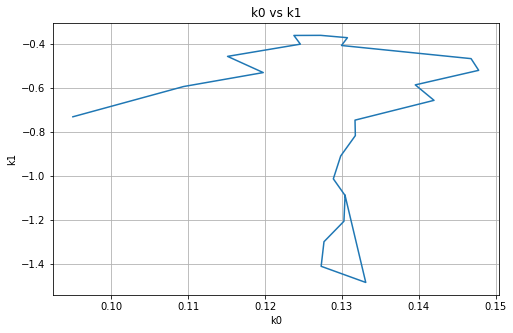

In [106]:
k0_2 = []
k1_2 = []
for idx in weights_dict2.keys():
    k0_2.append((weights_dict2[idx][1]))
    k1_2.append((weights_dict2[idx][2]))

plt.rcParams["figure.figsize"] = (8,5)
plt.plot(k0_2,k1_2)
plt.grid(True)
plt.title("k0 vs k1")
plt.xlabel("k0")
plt.ylabel("k1")
plt.show()

In [18]:
history2.params

{'verbose': 1, 'epochs': 50, 'steps': 1875}

In [19]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

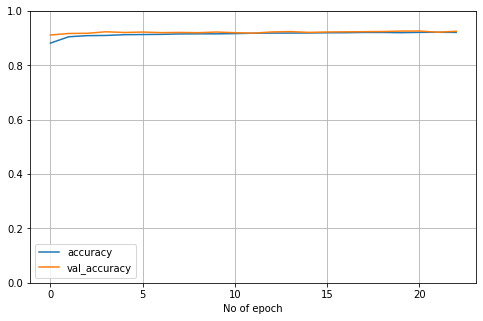

In [47]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(history2.epoch,pd.DataFrame(history2.history)[['accuracy','val_accuracy']])
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.legend(["accuracy","val_accuracy"])
plt.xlabel("No of epoch")
plt.show()

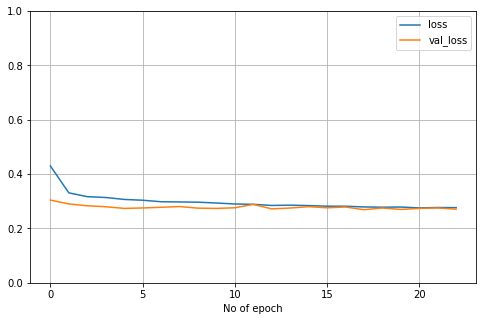

In [24]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(history2.epoch,pd.DataFrame(history2.history)[['loss','val_loss']])
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.legend(["loss","val_loss"])
plt.xlabel("No of epoch")
plt.show()

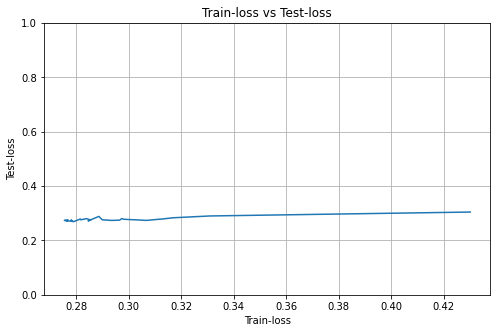

In [28]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(pd.DataFrame(history2.history)['loss'],pd.DataFrame(history2.history)['val_loss'])
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Train-loss vs Test-loss")
plt.xlabel("Train-loss")
plt.ylabel("Test-loss")
plt.show()

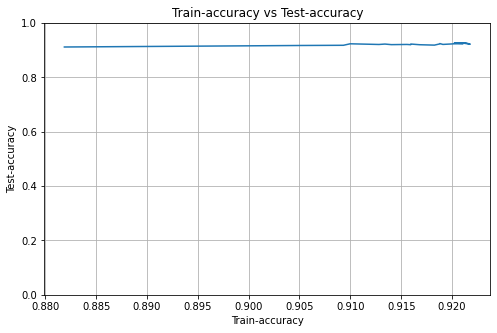

In [29]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(pd.DataFrame(history2.history)['accuracy'],pd.DataFrame(history2.history)['val_accuracy'])
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Train-accuracy vs Test-accuracy")
plt.xlabel("Train-accuracy")
plt.ylabel("Test-accuracy")
plt.show()

In [32]:
model2.evaluate(train_images, train_labels)

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2494 - accuracy: 0.9306


[0.24936386942863464, 0.930566668510437]

In [33]:
model2.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.2689 - accuracy: 0.9239


[0.2689381241798401, 0.9239000082015991]

In [46]:
pred_labels = model2.predict_classes(test_images)
f1_score(test_labels,pred_labels,average="weighted")

c:\users\deepd\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.9237073166256874

In [68]:
iris = datasets.load_iris()
X = iris["data"]
y = iris["target"]

In [69]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=42)

In [70]:
input_shape3 = X[0].shape

In [72]:
model3 = keras.Sequential([
    
    Adaact(64,input_shape=input_shape),
    keras.layers.Dropout(rate=0.2),
    Adaact(32),
    keras.layers.Dense(3,activation='softmax')
    
])
early_stopping_cb3 = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
weights_dict3 = {}
weight_cb3 = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: weights_dict3.update({epoch:model2.get_weights()}))


model3.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [88]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
adaact_1 (Adaact)            (None, 64)                322       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
adaact_2 (Adaact)            (None, 32)                2082      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 2,503
Trainable params: 2,503
Non-trainable params: 0
_________________________________________________________________


In [73]:
history = model3.fit(X_train,y_train, epochs=50, batch_size=12,validation_data=(X_test,y_test),
                     callbacks=[early_stopping_cb3,weight_cb3])

Epoch 1/50
10/10 [==============================] - 2s 44ms/step - loss: 1.3012 - accuracy: 0.3964 - val_loss: 0.8692 - val_accuracy: 0.6842
Epoch 2/50
10/10 [==============================] - 0s 12ms/step - loss: 0.8597 - accuracy: 0.6220 - val_loss: 0.7432 - val_accuracy: 0.8158
Epoch 3/50
10/10 [==============================] - 0s 12ms/step - loss: 0.7545 - accuracy: 0.6794 - val_loss: 0.6585 - val_accuracy: 0.7632
Epoch 4/50
10/10 [==============================] - 0s 15ms/step - loss: 0.7347 - accuracy: 0.6204 - val_loss: 0.6002 - val_accuracy: 0.7105
Epoch 5/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6965 - accuracy: 0.6429 - val_loss: 0.5474 - val_accuracy: 0.8158
Epoch 6/50
10/10 [==============================] - 0s 10ms/step - loss: 0.6242 - accuracy: 0.6477 - val_loss: 0.5112 - val_accuracy: 0.8158
Epoch 7/50
10/10 [==============================] - 0s 10ms/step - loss: 0.6031 - accuracy: 0.6690 - val_loss: 0.4738 - val_accuracy: 0.7895
Epoch 8/50
10

In [74]:
model3.evaluate(X_train,y_train)

4/4 [==============================] - 0s 3ms/step - loss: 0.0824 - accuracy: 0.9732


[0.08243776857852936, 0.9732142686843872]

In [75]:
model3.evaluate(X_test,y_test)

2/2 [==============================] - 0s 4ms/step - loss: 0.0576 - accuracy: 1.0000


[0.057601165026426315, 1.0]

In [103]:
for epoch,weights in weights_dict3.items():
    print("Value of k0 in epoch #",epoch+1)
    print(weights[1])
    print("Value of k1 in epoch #",epoch+1)
    print(weights[2])
    print("Value of kernel in epoch #",epoch+1)
    print(weights[0])
    print("Value of Bias in epoch #",epoch+1)
    print(weights[3])

Value of k0 in epoch # 1
[0.13041113]
Value of k1 in epoch # 1
[-1.0896251]
Value of kernel in epoch # 1
[[ 0.0180796  -0.04652152  0.01763599 ... -0.0654212   0.09099182
  -0.05437881]
 [-0.08810689 -0.06793077 -0.02375035 ... -0.08400621 -0.04089812
  -0.01803301]
 [-0.0619554  -0.00524685  0.01873137 ... -0.03946084 -0.04514297
   0.09283177]
 ...
 [-0.02824675  0.00569637 -0.00764325 ...  0.04950488 -0.01602927
  -0.06306607]
 [-0.03085351  0.00352899  0.01372383 ... -0.09228438  0.07128725
   0.03699109]
 [-0.06406836  0.01195095  0.0090136  ... -0.05536285 -0.02727608
   0.05153397]]
Value of Bias in epoch # 1
[-1.1673496e-03  1.3339492e-03 -2.9446408e-03 -2.8652232e-03
  7.4194674e-04 -1.9852694e-03 -1.7574726e-03 -4.4922839e-05
 -2.8589135e-03  2.5891203e-03  2.2133379e-03 -4.9366010e-03
  5.7422515e-04 -8.6590066e-05 -1.1198259e-03 -3.8489208e-04
  2.9157172e-04 -4.6150768e-04  8.2171783e-03  1.5236199e-03
 -4.5786265e-04 -1.2531228e-03  1.6478815e-03 -2.1160787e-03
  1.207622

In [104]:
model3.layers[0].get_weights()

[array([[-0.01531074, -0.10988583, -0.0990492 ,  0.21801828, -0.14186391,
          0.26763877, -0.2689032 ,  0.05055712, -0.30036685,  0.00885733,
          0.16080478,  0.19628584, -0.24830195, -0.00342613,  0.04711294,
         -0.02277725,  0.06571711,  0.02451397,  0.04214738,  0.17494023,
         -0.1628215 ,  0.02061324,  0.06742331,  0.00854561, -0.03132913,
          0.1019835 ,  0.0632732 , -0.11930731,  0.04578921,  0.22758327,
         -0.0742885 ,  0.04838803,  0.29779324, -0.10215285,  0.28522056,
          0.02103829, -0.11537879,  0.10768313,  0.18312714,  0.1689594 ,
          0.11797899, -0.04110967,  0.16570418,  0.28285658, -0.03114295,
         -0.08535429,  0.02000615,  0.29903257,  0.21583824, -0.02871652,
          0.08927203, -0.2870257 , -0.01415816,  0.2833035 ,  0.04625427,
         -0.14834133,  0.23728067,  0.16100661,  0.004193  , -0.03977815,
         -0.02526406,  0.06164674,  0.05361643,  0.11762766],
        [ 0.06623164, -0.16815193,  0.06338833, -0

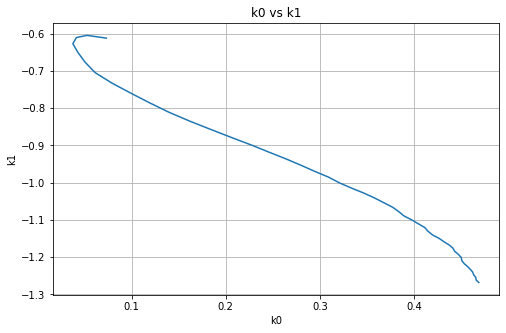

In [107]:
k0_3 = []
k1_3 = []
for idx in weights_dict3.keys():
    k0_3.append((weights_dict[idx][1]))
    k1_3.append((weights_dict[idx][2]))

plt.rcParams["figure.figsize"] = (8,5)
plt.plot(k0_3,k1_3)
plt.grid(True)
plt.title("k0 vs k1")
plt.xlabel("k0")
plt.ylabel("k1")
plt.show()

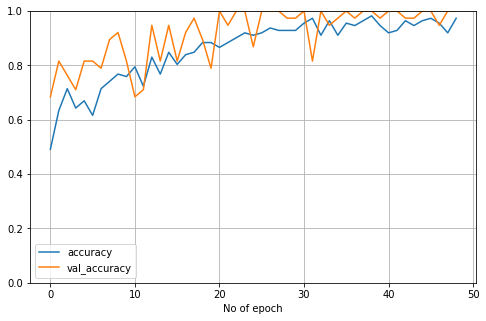

In [79]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(history.epoch,pd.DataFrame(history.history)[['accuracy','val_accuracy']])
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.legend(["accuracy","val_accuracy"])
plt.xlabel("No of epoch")
plt.show()

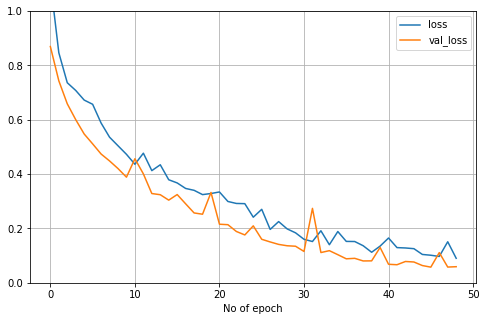

In [80]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(history.epoch,pd.DataFrame(history.history)[['loss','val_loss']])
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.legend(["loss","val_loss"])
plt.xlabel("No of epoch")
plt.show()

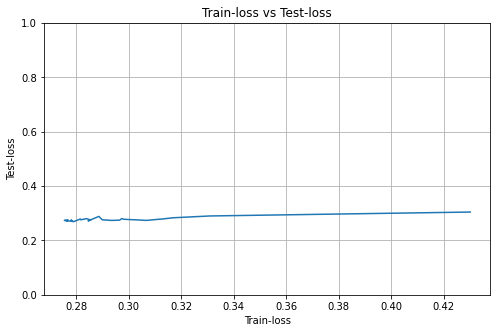

In [81]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(pd.DataFrame(history2.history)['loss'],pd.DataFrame(history2.history)['val_loss'])
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Train-loss vs Test-loss")
plt.xlabel("Train-loss")
plt.ylabel("Test-loss")
plt.show()

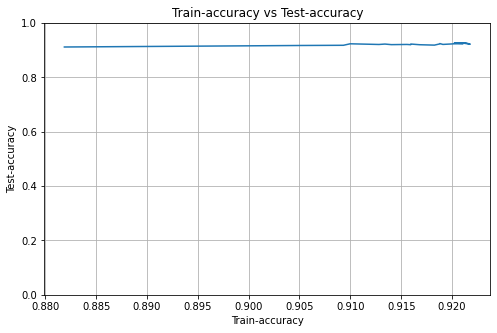

In [82]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(pd.DataFrame(history2.history)['accuracy'],pd.DataFrame(history2.history)['val_accuracy'])
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Train-accuracy vs Test-accuracy")
plt.xlabel("Train-accuracy")
plt.ylabel("Test-accuracy")
plt.show()

In [85]:
y_pred = model3.predict_classes(X_test)
f1_score(y_test,y_pred,average="weighted")

1.0